# Final Project for DNDS6288 - Scientific Python 2021/22 Fall
## Student: Abay Jumabayev
## [GitHub link](https://github.com/JustJAG/SciPy_final_project)
## 1. Introduction
I want to accomplish two things:
1. Assess the simple trading algorithm efficiency 
2. Predict the future stock prices of stocks

I will start with the description of the trading algorithm. The idea is to buy stock, hold them until the stock prices increases by $x$ percent, sell, and receive profits. Buy stock again if the price drops by $x$ percent from the moment of last transaction. Repeat this process again and again.

I need a stock with a volatile price for this algorithm to work. In this project, I will use Tesla (TSLA ticker) as it is trending and volatile. The stock under analysis can be changed in the code. 

Testing period is 1 year (which can be changed in the code). The data is the hourly data from Yahoo Finance.

I will compare the effectiveness of the algorithm with the S&P 500 ETF Trust (SPY ticker), which is considered to be a good option for beginning investors who don't want to interact with the stocks much.

Problem: Suppose an investor has 1000\$ and 1 year. Base option is to buy S&P 500 ETF Trust. The second option is to use an algorithm described above.

## 2. Getting and cleaning data
Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import scipy.stats as stats
import scipy.optimize as opt
import json as json
import matplotlib as mpl
from math import exp
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.lines import Line2D
from IPython.core.pylabtools import figsize
from IPython.display import display
from IPython.core.display import HTML
rnd.seed(2)
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

Choosing base and volatile stocks, choosing period and interval of analysis

In [2]:
# Choosing tickers for an analysis
base_ticker = "SPY"
algo_ticker = "TSLA"

# Choosing period of analysis and interval
period = "1y" # 1 year
interval = "60m" # 1 hour


Getting the data. Both SPY and TSLA separately

In [3]:
# # UNCOMMENT THIS TO DOWNLOAD THE DATA
# # Get the data
# base = yf.download(tickers=base_ticker, period=period, interval=interval)
# algo = yf.download(tickers=algo_ticker, period=period, interval=interval)

Save the raw data. We might need it for reproducability. I saved the data I downloaded on [github](https://github.com/JustJAG/SciPy_final_project)

First, define the folders

In [4]:
cd

C:\Users\77774


In [5]:
# location folders
data_in = ".\\Documents\\GitHub\\SciPy_final_project\\raw\\"
data_out = ".\\Documents\\GitHub\\SciPy_final_project\\clean\\"
results = ".\\Documents\\GitHub\\SciPy_final_project\\results\\"

In [6]:
# # UNCOMMENT THIS TO SAVE THE DATA
# # save raw data
# base.to_csv(data_in+'base_raw.csv',index=True)
# algo.to_csv(data_in+'algo_raw.csv',index=True)

For now, I will use the saved data. If you want to download the data from scratch, uncomment two cells above.

In [7]:
base = pd.read_csv(data_in+'base_raw.csv')
algo = pd.read_csv(data_in+'algo_raw.csv')

In [8]:
# convert Datetime column from string to datetime and change format
def clean_dates(df):
    df.Datetime = df.Datetime.map(lambda x: str(x)[:-6])
    df.Datetime = pd.to_datetime(df.Datetime, format = '%Y-%m-%d %H:%M:%S')
    return df
    
base = clean_dates(base)
algo = clean_dates(algo)

Let's draw the returns of these two tickers

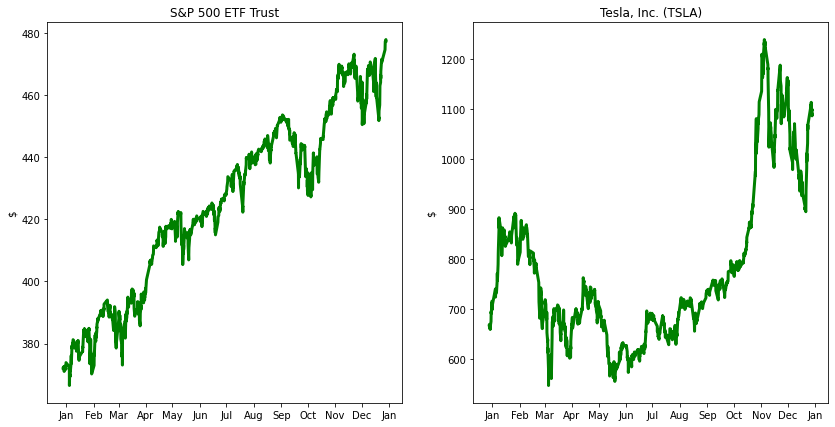

In [9]:
# create fig, axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7)) 

# first plot of Base
axes[0].plot(base.Datetime, base['Adj Close'], linewidth=3, color = 'green')
axes[0].set_ylabel('$')
axes[0].set_title('S&P 500 ETF Trust')

months = MonthLocator()
monthsFmt = DateFormatter("%b")
axes[0].xaxis.set_major_locator(months)
axes[0].xaxis.set_major_formatter(monthsFmt)

# second plot of Algo
axes[1].plot(algo.Datetime, algo['Adj Close'], linewidth=3, color = 'green')
axes[1].set_ylabel('$')
axes[1].set_title('Tesla, Inc. (TSLA)')

months = MonthLocator()
monthsFmt = DateFormatter("%b")
axes[1].xaxis.set_major_locator(months)
axes[1].xaxis.set_major_formatter(monthsFmt)

We can clearly see that SPY grows steadily while TSLA has some volatility.

## 3. Creating an algorithm

Below is a simple algorithm function. A function takes dataframe, prices, and threshold as an input. The dataframe is the volatile stock df we downloaded (algo), price is the stock price (*Adj close* column of the dataframe), and the threshold is the \% change threshold ($x$ from the description above).

The function will add three columns to the dataframe: *buy*, *sell*, and *returns*. *buy* and *sell* are the actions of buying or selling stocks (=1 if buy/sell, =0 otherwise). *returns* will give the cumulative returns.

In [10]:
def algorithm(df, stock_price, threshold):
    ### creating a list of actions
    buy_actions = [0] * len(stock_price)
    sell_actions = [0] * len(stock_price)
    
    ### add necessary variables
    pos = 0
    last_action = "Sell"
    
    ### loop through all prices
    for i in range(1,len(stock_price)):
        
        # algorithm takes the first price of the year and compares it to the subsequent prices
        checkpoint = stock_price[pos]
        
        # if price drops by x percent, buy the stock
        if last_action == "Sell":
            if (stock_price[i]-checkpoint)/checkpoint < -threshold:
                pos = i
                buy_actions[i] = 1
                last_action = "Buy"
        # if price increases by x percent, sell the stock        
        else:
            if (stock_price[i]-checkpoint)/checkpoint > threshold:
                pos = i
                sell_actions[i] = 1
                last_action = "Sell"
                
    ### add buy and sell columns to the dataframe
    df['buy_' + str(threshold)] = buy_actions
    df['sell_' + str(threshold)] = sell_actions
    
    ### add returns column to the dataframe
    df['returns_' + str(threshold)] = 1

    # create a temporary df that will calculate the returns
    df_temp = df.loc[(df['buy_' + str(threshold)] == 1) | (df['sell_' + str(threshold)] == 1)]
    # calculate percentage change from each buy-sell operation
    df_temp['percent'] = df_temp['Adj Close'].pct_change()
    df_temp = df_temp.loc[(df['sell_' + str(threshold)] == 1)]
    # calculate returns
    returns = [0]*len(df_temp['percent'])
    returns[0]=1+df_temp['percent'].iloc[0]
    for i in range(1, len(df_temp['percent'])):
        returns[i]=returns[i-1]*(1+df_temp['percent'].iloc[i])
    df_temp['returns'] = returns
    df_temp = df_temp.reset_index()
    df_temp = df_temp[["index","returns"]]
    
    # add returns column to the dataframe
    for i in range(len(df_temp)):
        df.loc[df_temp['index'].iloc[i]:, 'returns_' + str(threshold)] = df_temp.returns.iloc[i]


Run the algorithm with four different threshold values

I chose 1%, 3%, 5%, and 10%

In [11]:
thresholds = [0.01,0.03,0.05,0.1]
for i in thresholds:
    algorithm(algo,algo['Adj Close'], threshold=i)

Let's see the returns of the algorithm

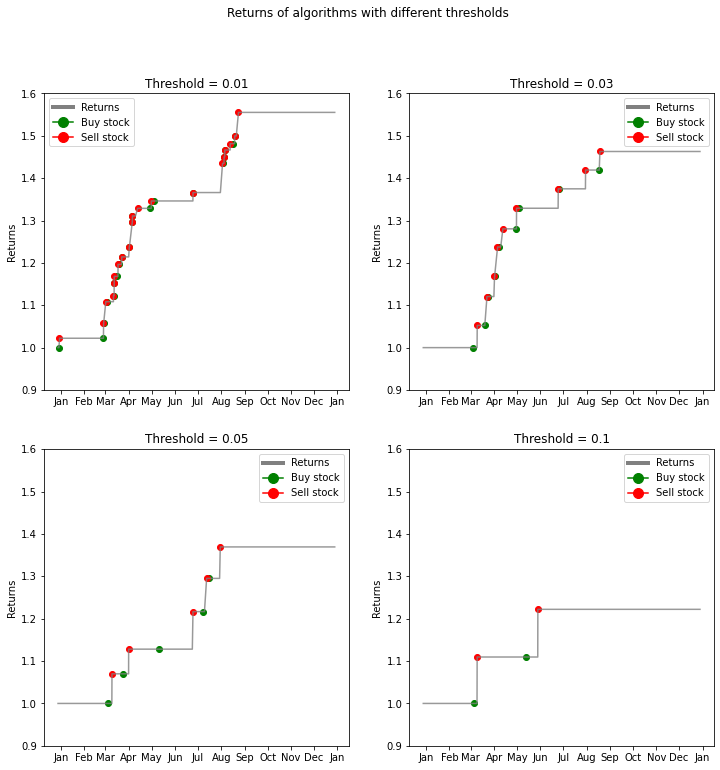

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12)) 
plt.suptitle('Returns of algorithms with different thresholds')
for plt, i in zip(axes.reshape(-1), thresholds):
    buy_df = algo[(algo['buy_'+str(i)]==1)]
    sell_df = algo[(algo['sell_'+str(i)]==1)]    
    
    plt.scatter(buy_df['Datetime'], buy_df['returns_'+str(i)],linestyle="solid", c = "green")
    plt.scatter(sell_df['Datetime'], sell_df['returns_'+str(i)],linestyle="solid", c = 'red')
    plt.plot(algo.Datetime,algo['returns_'+str(i)],c = "gray", alpha = 0.8)    
    
    # x axis as month names
    months = MonthLocator()
    monthsFmt = DateFormatter("%b")
    plt.xaxis.set_major_locator(months)
    plt.xaxis.set_major_formatter(monthsFmt)
    
    # Create legends
    legend_elements = [Line2D([0], [0], color='gray', lw=4, label='Returns'),
                       Line2D([0], [0], marker='o', color='green', label='Buy stock',
                              markerfacecolor='g', markersize=10),
                       Line2D([0], [0], marker='o', color='red', label='Sell stock',
                              markerfacecolor='r', markersize=10)]
    plt.legend(handles=legend_elements)
    
    # set title
    plt.set_title('Threshold = '+str(i))
    # set y label
    plt.set_ylabel('Returns')
    plt.set_ylim([0.9, 1.6])

As we can see, the higher the threshold, the less operations there will be. Moreover, the higher the threshold, the less returns one can get out of the algorithm trading.

156.54180656825392

In [14]:
algo

,Datetime,Open,High,Low,Close,Adj Close,Volume,buy_0.01,sell_0.01,returns_0.01,buy_0.03,sell_0.03,returns_0.03,buy_0.05,sell_0.05,returns_0.05,buy_0.1,sell_0.1,returns_0.1
0,2020-12-28 11:30:00,671.489990,673.549988,665.080017,668.013184,668.013184,0,0,0,1.000000,0,0,1.000000,0,0,1.000000,0,0,1.000000
1,2020-12-28 12:30:00,667.974976,671.449890,665.950012,668.927124,668.927124,2674064,0,0,1.000000,0,0,1.000000,0,0,1.000000,0,0,1.000000
2,2020-12-28 13:30:00,668.781799,669.659912,666.380005,668.102478,668.102478,1733599,0,0,1.000000,0,0,1.000000,0,0,1.000000,0,0,1.000000
3,2020-12-28 14:30:00,668.109985,669.140015,665.750000,666.684998,666.684998,1752353,0,0,1.000000,0,0,1.000000,0,0,1.000000,0,0,1.000000
4,2020-12-28 15:30:00,666.820007,668.039978,662.270020,663.770020,663.770020,2506717,0,0,1.000000,0,0,1.000000,0,0,1.000000,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,2021-12-27 15:30:00,1094.520020,1096.800049,1087.599976,1093.819946,1093.819946,1933350,0,0,1.555355,0,0,1.463042,0,0,1.369504,0,0,1.222179
1759,2021-12-28 09:30:00,1109.484985,1118.999878,1078.420044,1089.594971,1089.594971,7602055,0,0,1.555355,0,0,1.463042,0,0,1.369504,0,0,1.222179
1760,2021-12-28 10:30:00,1089.869995,1094.500000,1082.219971,1086.173950,1086.173950,2401300,0,0,1.555355,0,0,1.463042,0,0,1.369504,0,0,1.222179
1761,2021-12-28 11:30:00,1086.190063,1102.000000,1081.109985,1099.160034,1099.160034,2475542,0,0,1.555355,0,0,1.463042,0,0,1.369504,0,0,1.222179
